# Imports

In [1]:
import numpy as np
import joblib
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

from resources.context import Context as c
from resources.datatransformer import DataTransformer
from resources.modelvalidator import ModelValidator

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Data

## Loading Data

In [3]:
df_prepared = joblib.load(open((c().data_proc_fld() / 'df_prepared.pkl'), 'rb'))
ct_scaler = joblib.load(open(c().data_proc_fld() / 'ct_scaler.pkl', 'rb'))
ipvad_scaler = joblib.load(open(c().data_proc_fld() / 'ipvad_scaler.pkl', 'rb'))
y_scaler = joblib.load(open(c().data_proc_fld() / 'y_scaler.pkl', 'rb'))

## Data Preparation

### Data Reducion

In [4]:
# decided to filter some big numbers becuase they can distorce the models' results
df_prepared = df_prepared[df_prepared['log1p_leads'] < 2]

### Separation

In [5]:
X = df_prepared.drop(['cod_anuncio', 'log1p_leads'], axis=1)
y = df_prepared['log1p_leads']

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 5.0. Models Otimization & Features Impact

## 5.1. XGBoost

### 5.1.1. Fine Tuning

In [7]:
# param_grid = {
#             'max_depth': np.arange(3, 18, 3),
#             'gamma': np.arange(3, 9, 3),
#             'reg_alpha' : np.arange(30, 180, 30),
#             'reg_lambda' : np.arange(0, 1, 1),
#             'colsample_bytree' : np.arange(0.5, 1, 0.5),
#             'min_child_weight' : np.arange(0, 10, 2),
#             'n_estimators': np.arange(30, 150, 30)
#             }

In [8]:
# base_estimator = XGBRegressor(random_state=42)
# sh = RandomizedSearchCV(
#                 base_estimator, 
#                 param_grid, 
#                 cv=10, 
#                 n_jobs=-1, 
#                 scoring='neg_mean_absolute_error',
#                 ).fit(X, y)

In [9]:
#sh.best_params_

### 5.1.2. Fitting & Predicting

In [10]:
# these params was choosed by the fine tuning process above
xgb_params = {'reg_lambda': 0,
            'reg_alpha': 30,
            'n_estimators': 120,
            'min_child_weight': 8,
            'max_depth': 12,
            'gamma': 6,
            'colsample_bytree': 0.5,
            'objective':'reg:squarederror'}

xgb_model = XGBRegressor(**xgb_params)

### 5.1.3. Validations

In [11]:
xgb_model.fit(X, y)
model_validator = ModelValidator(model_name='XGBoost Regressor', model=xgb_model, X=X, y=y)
data_transformer = DataTransformer(df=X_val)

#### Shap

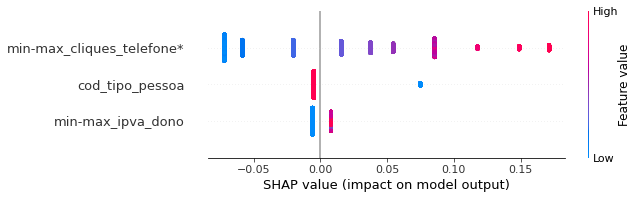

In [12]:
model_validator.shap_importance()

#### Feature Importance

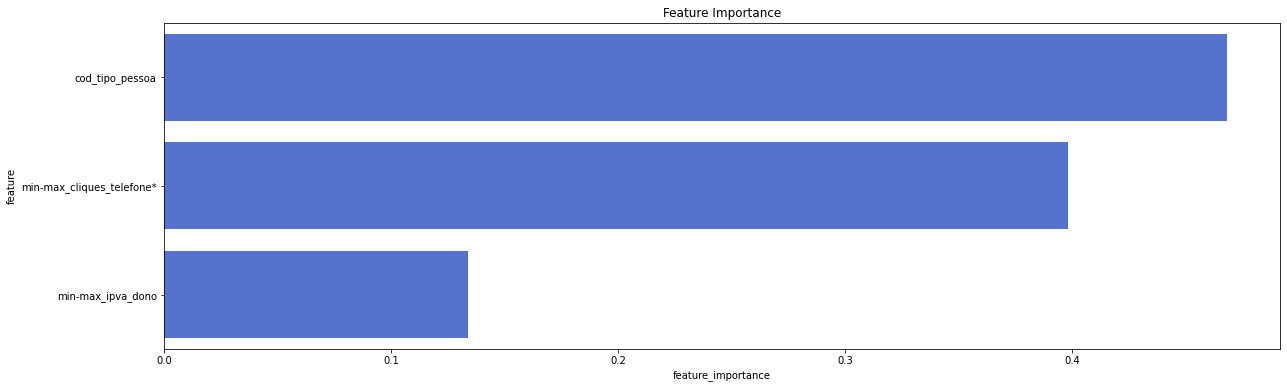

In [13]:
model_validator.plot_feature_importance()

## 5.2. Random Forest

### 5.2.1. Fine Tuning

In [14]:
# param_grid = {
#             'max_depth': np.arange(4, 16, 4),
#             'min_samples_leaf': np.arange(2, 6, 2),
#             'min_samples_split': np.arange(2, 6, 2),
#             'n_estimators': np.arange(30, 150, 30)
#             }

In [15]:
# base_estimator = RandomForestRegressor(random_state=42)
# sh = RandomizedSearchCV(
#                 base_estimator, 
#                 param_grid, 
#                 cv=10, 
#                 n_jobs=-1, 
#                 scoring='neg_mean_absolute_error',
#                 ).fit(X, y)

In [16]:
#sh.best_params_

### 5.2.2. Defining Model

In [17]:
# these params was choosed by the fine tuning process above
rf_params = {'n_estimators': 30,
            'min_samples_split': 4,
            'min_samples_leaf': 2,
            'max_depth': 4}

rf_model = RandomForestRegressor(**rf_params)

### 5.2.3. Validations

In [18]:
rf_model.fit(X, y)
model_validator = ModelValidator(model_name='Random Forest Regressor', model=rf_model, X=X, y=y)
data_transformer = DataTransformer(df=X_val)

#### Shap

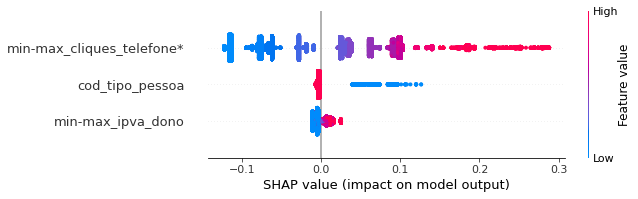

In [19]:
model_validator.shap_importance()

#### Feature Importance

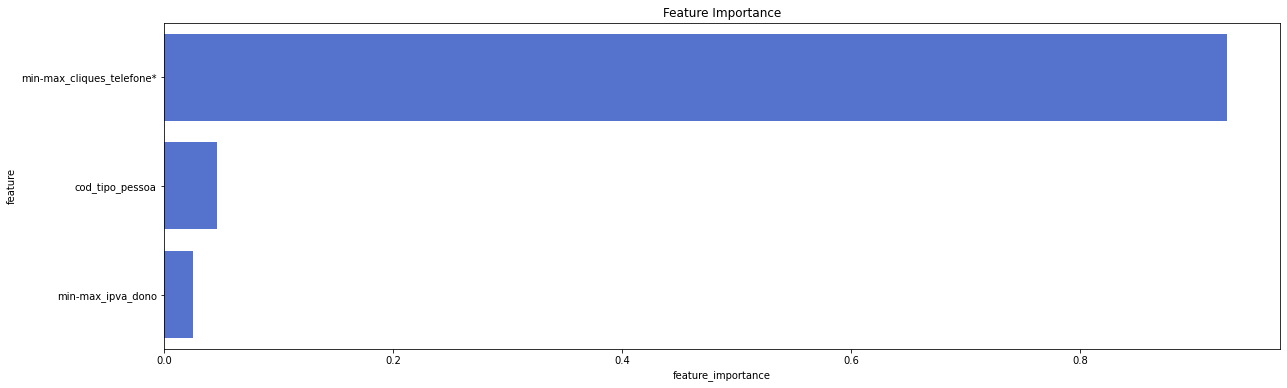

In [29]:
model_validator.plot_feature_importance()

## 5.3. K-Nearest Neighbour

### 5.3.1. Fine Tuning

In [20]:
param_grid = {
        'leaf_size': np.arange(5, 50, 5), 
        'n_neighbors': np.arange(5, 50, 5)
        }

In [21]:
base_estimator = KNeighborsRegressor()
sh = RandomizedSearchCV(
                base_estimator, 
                param_grid, 
                cv=10, 
                n_jobs=-1, 
                scoring='neg_mean_absolute_error',
                ).fit(X, y)

In [22]:
sh.best_params_

{'n_neighbors': 45, 'leaf_size': 35}

### 5.3.2. Defining Model

In [23]:
# these params was choosed by the fine tuning process above
knn_params = {'n_neighbors': 40, 'leaf_size': 5}

knn_model = KNeighborsRegressor(**knn_params)

## 5.4. Linear Regression

### 5.4.1. Defining Model

In [24]:
lr_model = LinearRegression()

## 5.5. Metrics

In [25]:
model_validator = ModelValidator(model_name='Extreme Gradient Boosting Regressor', model=xgb_model, X=X, y=y)
xgb_cv = model_validator.kfolds_cross_val(y_scaler=y_scaler, cv=10)

model_validator = ModelValidator(model_name='Random Forest Regressor', model=rf_model, X=X, y=y)
rf_cv = model_validator.kfolds_cross_val(y_scaler=y_scaler, cv=10)

model_validator = ModelValidator(model_name='K-Nearest Neighbour Regressor', model=knn_model, X=X, y=y)
knn_cv = model_validator.kfolds_cross_val(y_scaler=y_scaler, cv=10)

model_validator = ModelValidator(model_name='Linear Regression Regressor', model=lr_model, X=X, y=y)
lr_cv = model_validator.kfolds_cross_val(y_scaler=y_scaler, cv=10)

In [26]:
cv_perf = pd.concat([xgb_cv, rf_cv, knn_cv, lr_cv], axis=0)
cv_perf # Linear Regression get the best performance and is the simplest and lightest model, then he is the choosed model.

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Extreme Gradient Boosting Regressor,0.74,0.27,1.38
0,Random Forest Regressor,0.76,0.29,1.38
0,K-Nearest Neighbour Regressor,0.79,0.32,1.38
0,Linear Regression Regressor,0.74,0.27,1.37
